In [1]:
#########################################################################
## COMPROBAR GPU ASIGNADA EN COLABORATORY
#########################################################################
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jun 30 14:30:04 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.52.04              Driver Version: 555.52.04      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   63C    P5             20W /  100W |      64MiB /   6144MiB |      4%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
#########################################################################
## LIBRERIAS NECESARIAS
#########################################################################
import tensorflow as tf
import gymnasium as gym
from stable_baselines3 import PPO
from tensorflow.keras.layers import concatenate
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras import layers
from sklearn.model_selection import train_test_split

import os
from stable_baselines3.common.vec_env import DummyVecEnv

2024-06-30 14:30:04.389722: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-06-30 14:30:06.520073: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-06-30 14:30:06.520151: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-06-30 14:30:06.656179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-30 14:30:06.662980: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 Laptop GPU computeCapability: 8.6
coreClock: 1.605GHz coreCount: 30 deviceMemorySize: 5.70GiB deviceMemoryBandwidth: 312.97GiB/s
2024-06-30 14:30:06.662999: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-06-30 14:30:06.664035: I tensorflow/stream_executor/

In [4]:
############################################################################
## Variables globales (hiperparámetros)
###########################################################################
EPOCHS=1
BATCH_SIZE=140 # Regla de tres: Tamaño del dataset experto----batch size

EPISODES=10
EPISODES_EVALUATE_G=50

TOTAL_TIMESTEPS_PPO_GENERATOR=40000  # El experto en vez de 250000 tiene 20000 
LEARNING_RATE=0.001

# GYM Lunar Lander


* **Entorno**:

  Este entorno es un **problema clásico de optimización de trayectoria de un COHETE**. Según el principio del máximo de Pontryagin, es óptimo encender el motor a máxima potencia o apagarlo. Esta es la razón por la cual este entorno tiene acciones discretas: encender el motor o apagarlo.

 Existen dos versiones del entorno: discreta o continua. La plataforma de aterrizaje siempre se encuentra en las coordenadas (0,0). Las coordenadas son los primeros dos números en el vector de estado. Es posible aterrizar fuera de la plataforma de aterrizaje. El combustible es infinito, por lo que un agente puede aprender a volar y luego aterrizar en su primer intento.

* **Acciones**: tenemos cuatro acciones discretas:

  * **0**:No hacer nada
  * **1**: Encender motor de orientación izquierdo
  * **2**: Encender motor principal
  * **3**: Encender motor de orientación derecho
* **Observaciones**: es un vector de 8 dimensiones donde se almacenan las coordenadas (x,y), las velocidades lineales en x e y, su ángulo, su velocidad angular, y dos booleanos que representan si cada pata está en contacto con el suelo o no.


In [5]:
#!cd pybox2d && python setup.py build && python setup.py install

In [6]:
# Definimos el entorno
env = gym.make("LunarLander-v2")

# Obtenemos el espacio de estados y acciones del entorno
ob_space=env.observation_space
ac_space=env.action_space

# Mostramos el número de acciones del entorno
print(env.action_space.n)
# Mostramos el número de observaciones del entorno
print(ob_space.shape[0])

4
8


# Discriminador

## Red neuronal del Discriminador

In [7]:
################################################################################################################################################
# Red neuronal del Discriminador
################################################################################################################################################

# Input: secuencias [s,a,s',r] reales o sintéticas, de longitud 2*ob_space.shape[0] + ac_space.n+1.
# Output: probabilidad de que la secuencia sea real, valor perteneciente al intervalo [0,1]
discriminator_net=keras.Sequential(
    [
        keras.Input(shape=(None, 2*ob_space.shape[0] + ac_space.n+1)),
        layers.Dense(units=10,activation=tf.nn.relu, name='layer1'),
        layers.Dense(units=10,activation=tf.nn.relu, name='layer2'),
        layers.Dense(units=10, activation=tf.nn.relu, name='layer3'),
        layers.Dense(units=1, activation=tf.sigmoid, name='prob'),

    ],
    name="discriminator_net"

)
discriminator_net.summary()

2024-06-30 14:30:06.740244: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-30 14:30:06.741062: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-06-30 14:30:06.741223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-30 14:30:06.746424: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 Laptop GPU computeCapability: 8.6
coreClock: 1.605GHz coreCount: 30 deviceMemorySize: 5.70GiB deviceMemoryBandwid

Model: "discriminator_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, None, 10)          220       
_________________________________________________________________
layer2 (Dense)               (None, None, 10)          110       
_________________________________________________________________
layer3 (Dense)               (None, None, 10)          110       
_________________________________________________________________
prob (Dense)                 (None, None, 1)           11        
Total params: 451
Trainable params: 451
Non-trainable params: 0
_________________________________________________________________


## Función de pérdida del Discriminador

In [8]:
#########################################################################################################
# Función de pérdida del Discriminador
#########################################################################################################

# prob1=> output de la red neuronal del Discriminador cuando recibe como entrada una secuencia REAL [s,a, s', r] de la base de datos
# prob2=> output de la red neuronal del Discriminador cuando recibe como entrada una secuencia FALSA [s,a, s', r]
def loss_fn_D(prob1, prob2):

    # Esperanza del logaritmo de la D(x)=salida de la red neuronal cuando x=entrada REAL
    loss_expert = tf.reduce_mean(tf.math.log(tf.clip_by_value(prob1, 0.01, 1)))

    # Esperanza del logaritmo de 1-D(x) donde D(x)=salida de la red neuronal cuando x=entrada FALSA
    loss_agent = tf.reduce_mean(tf.math.log(tf.clip_by_value(1 - prob2, 0.01,1)))

    loss_expert = tf.cast(loss_expert, dtype=tf.float32)
    loss_agent = tf.cast(loss_agent, dtype=tf.float32)

    loss = loss_expert + loss_agent

    loss = -loss

    return loss

## Clase del Discriminador

In [9]:
# Clase DISCRIMINADOR
class Discriminator:
    def __init__(self, env, discriminator_net, expert_s, expert_a, expert_s_prima, expert_r, agent_s, agent_a, agent_s_prima, agent_r):
        # -Red neuronal del Discriminador
        self.discriminator_net=discriminator_net

        # -Experto: [s,a,s',r]
        self.expert_s=expert_s
        self.expert_a=expert_a
        self.expert_s_prima=expert_s_prima
        self.expert_r= np.array(expert_r)


        expert_a_one_hot=tf.one_hot(self.expert_a,depth=env.action_space.n)
        # Añadimos ruido para estabilizar el entrenamiento
        expert_a_one_hot+= tf.random.normal(tf.shape(expert_a_one_hot), mean=0.2, stddev=0.1, dtype=tf.float32)/1.2
        expert_s_a=tf.concat([self.expert_s,expert_a_one_hot],axis=1)
        expert_s_a_s=tf.concat([expert_s_a, self.expert_s_prima], axis=1)
        expert_r=self.expert_r.reshape(-1, 1)

        # expert_s_a_s_r=>secuencia experta=>[s,a,s',r]
        self.expert_s_a_s_r=tf.concat([expert_s_a_s, expert_r], axis=1)

        # -Agente:  [s,a,s',r]
        self.agent_s=agent_s
        self.agent_a=agent_a
        self.agent_s_prima=agent_s_prima
        self.agent_r=np.array(agent_r)

        agent_a_one_hot=tf.one_hot(self.agent_a,depth=env.action_space.n)
        agent_a_one_hot+= tf.random.normal(tf.shape(agent_a_one_hot), mean=0.2, stddev=0.1, dtype=tf.float32)/1.2
        agent_s_a=tf.concat([self.agent_s,agent_a_one_hot],axis=1)
        agent_s_a_s=tf.concat([agent_s_a, self.agent_s_prima], axis=1)
        agent_r=self.agent_r.reshape(-1, 1)

        # agent_s_a_s_r=>secuencia agente=>[s,a,s',r]
        self.agent_s_a_s_r=tf.concat([agent_s_a_s, agent_r], axis=1)

        # Calculamos la salida de la red para [s,a,s',r] del experto y del agente ya que lo necesitamos para reward

        # -Salida de la red neuronal Discriminador para [s,a,s',r] expertos(verdaderos)
        self.prob_expert=self.discriminator_net(self.expert_s_a_s_r)

        # -Salida  de la red neuronal Discrimiinador para [s,a,s',r] Agente(falsos)
        self.prob_agent=self.discriminator_net(self.agent_s_a_s_r)

        #-Recompensa obtenida cuando el Agente realiza [s,a,s',r] falsas
        self.rewards=tf.math.log(tf.clip_by_value(self.prob_agent,1e-10,1)) #log(P(expert|s,a)) cuando mas grande es mejor el agente


    def getNet(self):
        return self.discriminator_net

    def getAgent_S_A(self):
        return self.agent_s_a

    def getExpert_S_A(self):
        return self.expert_s_a

    def getProb(self):
        return self.prob_expert, self.prob_agent

    def getRewards(self):
        return self.rewards


# Generador

## Redes neuronales del Generador

In [10]:
#####################################################################################################
# Red neuronal del Generador donde se producen acciones
####################################################################################################

# Input: estados, listas de tamaño 8, s=[s1,s2,s3,s4,...,s8]
# Output: acciones, listas de tamaño 4, a=[a1,a2,a3,a4]
generator_net_Act = keras.Sequential(
    [
        keras.Input(shape=(None, ob_space.shape[0])),
        layers.Dense(units=6, activation="sigmoid",name='layer1'),
        layers.Dense(units=6, activation="sigmoid", name='layer2'),
        layers.Dense(units=4, activation="sigmoid", name='layer3'),
        layers.Dense(units=ac_space.n, activation=tf.nn.softmax, name='layer4')

    ],
    name="generator_net_Act"
)

generator_net_Act.summary()

Model: "generator_net_Act"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, None, 6)           54        
_________________________________________________________________
layer2 (Dense)               (None, None, 6)           42        
_________________________________________________________________
layer3 (Dense)               (None, None, 4)           28        
_________________________________________________________________
layer4 (Dense)               (None, None, 4)           20        
Total params: 144
Trainable params: 144
Non-trainable params: 0
_________________________________________________________________


In [11]:
#############################################################################################################
# Red neuronal del Generador donde se producen v_pred
#############################################################################################################

# Input: estados, listas de tamaño 8, s=[s1,s2,s3,..,s8]
# Output: v_pred, listas de tamaño 1, v_pred

generator_net_v_preds=keras.Sequential(
    [
            keras.Input(shape=(None,ob_space.shape[0])),
            layers.Dense(units=6, activation="sigmoid",name='layer1'),
            layers.Dense(units=6, activation="sigmoid", name='layer2'),
            layers.Dense(units=1, activation=None, name='layer3'),
        ],
    name="generator_v_preds"
)

generator_net_v_preds.summary()

Model: "generator_v_preds"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, None, 6)           54        
_________________________________________________________________
layer2 (Dense)               (None, None, 6)           42        
_________________________________________________________________
layer3 (Dense)               (None, None, 1)           7         
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________


## Función de pérdida del Generador

In [12]:
##################################################################################################################
# Función de pérdida del Generador: función objetivo de PPO "clipped surrogated"
#################################################################################################################

def loss_fn_ppo(act_probs,act_probs_old,gaes,clip_value=0.2):
    ratios = tf.exp(tf.math.log(tf.clip_by_value(act_probs, 1e-10, 1.0))
                    - tf.math.log(tf.clip_by_value(act_probs_old, 1e-10, 1.0)))

    clipped_ratios = tf.clip_by_value(ratios,clip_value_min=1 -clip_value,clip_value_max=1 +clip_value)
    loss_clip = tf.minimum( tf.multiply(gaes, ratios), tf.multiply(gaes, clipped_ratios))
    loss_clip = tf.reduce_mean(loss_clip)

    loss = -loss_clip
    tf.summary.scalar('total', loss)

    return loss

## Clase del Generador

In [13]:
#################################################################################################################
# Clase del GENERADOR: política con su optimizador PPO
################################################################################################################

# Observesé que cada generador implementa una política distinta, por tanto, se ha decidido llamar a la clase Policy_net en lugar de generator
class Policy_net:
    def __init__(self, name: str, env, obs):
        """
        name: string
        env: gym env
        obs:
        """

        # -Entorno
        self.env=env
        env.reset()

        # -Modelo PPO: algoritmo de Optimización de Política Proximal
        self.model=PPO(policy="MlpPolicy", env=env, verbose=0)


        self.model.learn(total_timesteps=TOTAL_TIMESTEPS_PPO_GENERATOR)

        # -Observación inicial a partir de la cual se crean las acciones iniciales haciendo uso de las redes neuronales del generador
        self.obs=np.reshape(np.array(obs),(1,ob_space.shape[0]))

        # Utilizamos las dos redes neuronales que hemos creado : generator_net_Act y generator_net_v_preds
        # V_pred=>recompensa media de que un agente ejecute una acción

        # -Acción inicial generada con red neuronal y v_pred con red neuronal
        self.act_probs =generator_net_Act(self.obs)
        self.v_preds = generator_net_v_preds(self.obs)

        # -Accion estocástica inicial
        self.act_stochastic = tf.random.categorical(tf.math.log(self.act_probs), num_samples=1)

        # -Acción determinística inicial
        self.act_deterministic = tf.argmax(self.act_probs, axis=1)



    # Para cada estado obs me dice la acción que el agente va a ejecutar sobre el entorno junto con v_pred
    # La elección de la acción puede ser estocástica o determinística
    def act(self, stochastic=True):
        if stochastic:
            return self.act_stochastic, self.v_preds
        else:
            return self.act_deterministic, self.v_preds

    def get_action_prob(self):
        return self.act_probs

    def get_v_preds(self):
        return self.v_preds

    def get_obs(self):
        return self.obs

    def get_model(self):
        return self.model

    # Devuelve los parámetros \theta de la política \pi
    def get_trainable_variables(self):
        return self.model.get_parameters()

    # Generar [s,a,s',r] sinteticos
    def generate_fakes(self):

        ob_space = env.observation_space
        reward = 0

        # Por cada episodio
        for iteration in range(EPISODES):
            # Inicializo todas las variables
            observations = []
            actions = []
            rewards = []
            next_observations=[]

            run_policy_steps = 0

            truncated=False
            terminated=False


            # La primera acción de cada episodio se crea con la red neuronal
            obs,_=env.reset()

            Old_Policy = Policy_net('old_policy', env, obs=obs)

            act, v_pred = Old_Policy.act(stochastic=True)

            #Convertir de tensor a array
            if type(act)=='Tensor':
                # Crear una sesión de TensorFlow
                sess = tf.compat.v1.Session()

                # Evaluar el tensor dentro de la sesión y obtener el resultado como un objeto NumPy ndarray
                act = sess.run(act)

                # Cerrar la sesión
                sess.close()

            if isinstance(act, tf.Tensor):
                act=act.numpy()

            elif isinstance(act, np.ndarray):
                act=act


            action=int(act)

            next_obs,reward,terminated,truncated, info=env.step(action)

            truncated=False
            terminated=False

            # Tenemos una política entrenada
            Policy = Policy_net('policy',env, obs=[next_obs])

            # Por cada steps en cada episodio, mientras no se llegue a un estado terminal o un estado malo
            while terminated!= True and truncated!= True:
                # --Aumentar el numero de steps
                run_policy_steps += 1

                # --Política para ver la acción asociada al estado
                # Las observaciones son un de la forma [[s_1,s_2,s_3,...,s_8]] por eso su tamaño es (1,8)
                observations.append(next_obs)  # S_i-1

                action, states_oc = Policy.get_model().predict(next_obs)

                action=int(action)

                # --Muevo al Agente al siguiente estado
                next_obs,reward,terminated,truncated,info=env.step(action)

                # --Actualización de variables
                actions.append(action) # A_i-1
                rewards.append(reward) # R_i-1

                # --Si llegamos a un estado final, el juego ha finalizado!!!
                # --Se configura el tablero de nuevo
                if terminated== True or truncated==True:
                    next_observations.append(next_obs)  # S_i
                    obs = env.reset()
                    reward = -1
                    break
                else:
                    next_observations.append(next_obs)  # S_i
                    self.obs = next_obs



        observations = np.reshape(observations, newshape=[-1] + list(ob_space.shape))
        next_observations = np.reshape(next_observations, newshape=[-1] + list(ob_space.shape))
        actions = np.array(actions).astype(dtype=np.int32)


        # Devolvemos la secuencia (S,A,S',R) junto con la política anterior y la actual política,
        return observations, actions, next_observations, rewards, Old_Policy, Policy

In [14]:
##########################################################################################################
# Clase PPOTrain
##########################################################################################################
# Tenemos dos politica theta_i y theta_i+1
# Almacenamos dos políticas Policy_net(cada una de ella con su PPO) y calculamos el valor gaes a partir de valores gamma, clip_value, c_1, c_2
# Realizamos aqui el entrenamiento, cálculo de gradiente y función de pérdida del PPO para después usarlo en el generador de la GAN

class PPOTrain:

    def __init__(self, Policy, Old_Policy, obs, actions, rewards, gamma=0.95, clip_value=0.2, c_1=1, c_2=0.01):
        """
        arg:
            Policy
            Old_Policy
            gamma
            clip_value
            c_1 parámetro para la diferencia de valores
            c_2 parámetro para el bonus de entropía
        """
        self.Policy = Policy
        self.Old_Policy = Old_Policy
        self.gamma = gamma
        self.obs=obs

        self.pi_trainable = self.Policy.get_trainable_variables()
        self.old_pi_trainable = self.Old_Policy.get_trainable_variables()


        policy_name = "policy"
        old_policy_name="policy"

        policy_dict_ = self.pi_trainable[policy_name]
        old_policy_dict_=self.old_pi_trainable[old_policy_name]

        self.pi=[]
        if policy_name in self.pi_trainable and old_policy_name in self.old_pi_trainable:
            for param_name, param_value in policy_dict_.items():
                # Elimino los pesos que hay en old_policy
                del old_policy_dict_[param_name]
                # Introduzco los pesos de old_policy en policy
                old_policy_dict_[param_name] = param_value
                self.pi.append(param_value)
        else:
            print(f"No se encontró la política con el nombre: {policy_name}")


        # Le asignamos old_pi_trainable=pi_trainable ya que ajustaremos unos nuevos pi_trainable


        self.actions = actions
        self.rewards=rewards
        self.v_preds=self.Old_Policy.get_v_preds()
        self.v_preds_next=self.Policy.get_v_preds()

        #  generative advantage estimator(lambda = 1), ver ppo paper eq(11)
        self.gaes =self.get_gaes(self.rewards, self.v_preds, self.v_preds_next)

        act_probs =self.Policy.get_action_prob()
        act_probs_old =self.Old_Policy.get_action_prob()

        # la probabilidad de las acciones del agente cuando toma la actual política
        act_probs = act_probs * tf.one_hot(indices=self.actions, depth=act_probs.shape[1])
        self.act_probs = tf.reduce_sum(act_probs, axis=1)

        # la probabilidad de las acciones del agente cuando toma la antigua política
        act_probs_old = act_probs_old * tf.one_hot(indices=self.actions, depth=act_probs_old.shape[1])
        self.act_probs_old = tf.reduce_sum(act_probs_old, axis=1)

        self.loss=loss_fn_ppo(self.act_probs, self.act_probs_old, self.gaes)

        self.optimizer =tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

    def loss_fn_G(self):
        return loss_fn_ppo(self.act_probs, self.act_probs_old, self.gaes)

    def get_pi_trainable(self):
        return self.pi

    def get_optimizer(self):
        return self.optimizer

    def get_OldPolicy(self):
        return self.Old_Policy

    def get_Policy(self):
        return self.Policy

    def get_gaes(self, rewards, v_preds, v_preds_next):
        deltas = [r_t + self.gamma * v_next - v for r_t, v_next, v in zip(rewards, v_preds_next, v_preds)]
        # calcular la estimación generative advantage (lambda = 1), ver ppo paper eq(11)
        gaes = copy.deepcopy(deltas)
        for t in reversed(range(len(gaes) - 1)):  # es T-1, donde T es timestep con el que se ejecuta la política
            gaes[t] = gaes[t] + self.gamma * gaes[t + 1]
        return gaes

# GAIL

In [15]:
####################################################################################################################
# CLASE GAIL
####################################################################################################################
class GAN(keras.Model):
    # Constructor
    def __init__(self, discriminator, generator):
        super().__init__()
        self.discriminator = discriminator
        self.generator=generator
        self.i=0
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    # Compila el modelo GAN inicializando los optimizadores y la función de pérdida del modelo GAN
    def compile(self,d_optimizer, loss_fn_D ):
        super(GAN, self).compile(run_eagerly=True)
        self.d_optimizer = d_optimizer
        self.loss_fn_D=  loss_fn_D

    # Devuelve las métricas obtenidas con el generador y discriminador
    @property
    def metrics(self):
        return [self.d_loss_metric,self.g_loss_metric]

    # Evaluación del Discriminador
    def evaluate_D(self, X_test):
        len_real = X_test.shape[0]

        generate_observations, generate_actions, generate_next_observations, rewards, Old_Policy, Policy=self.generator.generate_fakes()

        generate_a_one_hot=np.eye(env.action_space.n)[generate_actions]

        dataset_gen1=np.concatenate([generate_observations,generate_a_one_hot],axis=1)

        dataset_gen2= np.concatenate([dataset_gen1,generate_next_observations], axis=1)

        rewards=np.array(rewards).reshape(-1, 1)

        dataset_gen= np.concatenate([dataset_gen2,rewards], axis=1)


        len_fakes=dataset_gen.shape[0]

        # Compilamos el discriminador como CNN
        self.discriminator.discriminator_net.compile(optimizer=self.d_optimizer, loss=self.loss_fn_D, metrics=['accuracy'])

        # Evaluamos como CNN
        loss_real, acc_real=self.discriminator.discriminator_net.evaluate(X_test, tf.ones((len_real,1)), batch_size=len_real, verbose=1)

        loss_fake, acc_fake=self.discriminator.discriminator_net.evaluate(dataset_gen,tf.ones((len_fakes,1)), batch_size=len_fakes, verbose=1)

        print('>Loss real: ')
        print(loss_real)
        print('>Loss fake: ')
        print(loss_fake)


    # Evaluación del generador
    def evaluate_G(self):
        # Definimos el entorno
        env= gym.make('LunarLander-v2')

        # Lista donde amacenaremos la recompensa acumulada de cada episodio.
        # NUESTRO OBJETIVO: Agente aprenda a tomar las acciones que maximicen la recompensa
        rewards=[]

        # Para cada episodio, el Agente se mueve por el Entorno mediante acciones hasta llegar a un estado final
        # siguiendo la política que se ha aprendido en el entrenamiento de la GAN
        for episode in range(EPISODES_EVALUATE_G):
            truncated=False
            terminated=False
            R=0.0
            reward=0.0

            # Estado inicial del juego
            obs,_=env.reset()

            #Interactuamos con el Entorno hasta que lleguemos a un estado final
            while terminated!= True and truncated!=True:
                action, _=self.generator.get_model().predict(obs)
                obs,reward,terminated,truncated, info=env.step(int(action))

                # Incremento la recompensa del episodio i al haber ejecutado el step
                R+=reward

            rewards.append(R)

            # Vemos para el episodio, su recompensa acumulada que es lo que se trata de maximizar
            print("Episode  {} Total reward: {}".format(episode,R))

        # Cierro el entorno
        env.close()

        # Muestro las recompensas obtenidas en cada episodio
        indices = range(0, EPISODES_EVALUATE_G)
        plt.plot(indices,rewards)
        plt.show()

        return np.mean(rewards)

    def train_step(self, X_train):

        # 1) Generamos secuencias falsas [s,a,s',r]
        generate_observations, generate_actions, generate_next_observations, rewards, Old_Policy, Policy=self.generator.generate_fakes()

        generate_a_one_hot=np.eye(env.action_space.n)[generate_actions]

        if generate_observations.shape[0] == generate_a_one_hot.shape[0]:
          dataset_gen1 = np.concatenate([generate_observations, generate_a_one_hot], axis=1)
        else:
          generate_a_one_hot_resized = np.resize(generate_a_one_hot, generate_observations.shape)
          dataset_gen1 = np.concatenate([generate_observations, generate_a_one_hot_resized], axis=1)

        if generate_next_observations.shape[0] == generate_a_one_hot.shape[0]:
          dataset_gen2=np.concatenate([dataset_gen1, generate_next_observations], axis=1)
        else:
           generate_next_observations_new= np.resize(generate_next_observations, generate_observations.shape)
           dataset_gen2=np.concatenate([dataset_gen1, generate_next_observations_new], axis=1)

        rewards=np.array(rewards).reshape(-1,1)

        dataset_gen=np.concatenate([dataset_gen2, rewards], axis=1)

        # 2) Seleccionamos la muestra de datos generador con la que vamos a trabajar en este  batch de entrenamiento 
        #if len(dataset_gen) >= BATCH_SIZE: 
        random_indices = np.random.choice(len(dataset_gen), size=min(BATCH_SIZE,len(dataset_gen)), replace=False)
        dataset_gen= dataset_gen[random_indices[0]]


        # 3) Obtenemos las secuencias reales [s,a,s',r] de los datos de entrenamiento y las combinamos
        dataset_gen=dataset_gen.reshape(1,-1)
        combined_images = tf.concat([X_train, dataset_gen], axis=0)

        # 4) Las etiquetas de las imagenes combinadas las tenemos que crear nosotros introduciendo algo de ruido con tf.random.uniform
        labels = tf.concat( [tf.ones((BATCH_SIZE, 1)), tf.zeros((BATCH_SIZE, 1))], axis=0 )
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        ##############################################################################################################################################################
        # PASO 1:  ENTRENAMIENTO DEL DISCRIMINADOR
        #############################################################################################################################################################


        # Entrenamiento del discriminador con las [s,a, s', r] del agente(falsas o sintéticas) y del experto (reales) combinadas, esto es,
        # le pasamos un conjunto que tiene tanto secuencias reales como secuencias sintéticas
        with tf.GradientTape() as tape:
            predictions=np.zeros((2*BATCH_SIZE,6))
            # Predicciones obtenidas con el discriminador
            predictions = self.discriminator.discriminator_net(combined_images)
            # Valor de la función de pérdida al comparar las predicciones con las etiquetas reales
            d_loss = self.loss_fn_D(labels, predictions)

        # Calculo del gradiente y actualización del gradiente
        grads = tape.gradient(d_loss, self.discriminator.getNet().trainable_weights)

        self.d_optimizer.apply_gradients(
          zip(grads, self.discriminator.getNet().trainable_weights)
        )



        ################################################################################################################################################################
        # PASO 2: ENTRENAMIENTO DEL GENERADOR=POLÍTICA
        ###############################################################################################################################################################


        ppotrain=PPOTrain(Policy,Old_Policy,actions=generate_actions,rewards=rewards, obs=generate_observations) #       generate_observations[0])


        with tf.GradientTape() as tape:
            g_loss = ppotrain.loss_fn_G()


        g_loss = tf.cast(g_loss, dtype=tf.float32)

         ############################################################################################################################################################

        # Actualización de métricas del discriminador y generador
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        print("\n")
        print("\nd_loss=",d_loss.numpy())
        print("\ng_loss=",g_loss.numpy())

        return {"d_loss": self.d_loss_metric.result(),
                    "g_loss": self.g_loss_metric.result()}



# Experimentación de GAIL con LunarLander

## Experimento 1

### Construcción de base de datos experta con 1 trayectoria 

In [16]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_LunarLander.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]

	 Estados siguientes: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]

	 Recompensas: [   0    0   

In [17]:
longitud_trayectoria = np.count_nonzero(expert_num_tray == 0)
print(longitud_trayectoria)

547


In [18]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [19]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [20]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 437
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 110


In [21]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

2024-06-30 14:30:47.074233: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


### Definición de GAIL

In [22]:
gan1=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [23]:
tf.config.run_functions_eagerly(True)
gan1.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [25]:
import copy

In [26]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE=140

history=gan1.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)


/home/usuario/miniconda3/envs/luna/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(





d_loss= 2.6523206

g_loss= 12.188827
1/4 [======>.......................] - ETA: 31:49 - d_loss: 2.6523 - g_loss: 12.1888


d_loss= 2.6103354

g_loss= 2.1239977
2/4 [==============>...............] - ETA: 20:48 - d_loss: 2.6313 - g_loss: 7.1564 


d_loss= 2.6014752

g_loss= 3.1145947
3/4 [=====================>........] - ETA: 10:26 - d_loss: 2.6214 - g_loss: 5.8091


d_loss= 2.6100564

g_loss= -0.7078649
4/4 [==============================] - 2512s 625s/step - d_loss: 2.6185 - g_loss: 4.1799


### Evaluación de GAIL

In [27]:
# Evaluamos el Discriminador de GAIL en el TEST
gan1.evaluate_D(X_test)


1/1 [==============================] - 0s 16ms/step - loss: 0.7535 - accuracy: 0.6556
>Loss real: 
0.6949352025985718
>Loss fake: 
0.753487765789032


Episode  0 Total reward: -65.7771318149868
Episode  1 Total reward: -69.11403330440373
Episode  2 Total reward: -6.62966651550819
Episode  3 Total reward: -110.27551078957575
Episode  4 Total reward: -17.13488093176433
Episode  5 Total reward: -99.35392320693079
Episode  6 Total reward: 114.74406917334476
Episode  7 Total reward: -122.61525200420188
Episode  8 Total reward: -21.656260281118207
Episode  9 Total reward: 1.5861528605596362
Episode  10 Total reward: 115.59498097490633
Episode  11 Total reward: 139.630547558069
Episode  12 Total reward: -118.54064767354019
Episode  13 Total reward: -35.722233939569875
Episode  14 Total reward: -76.74243831910235
Episode  15 Total reward: -109.44244541462133
Episode  16 Total reward: -69.10217827208449
Episode  17 Total reward: -25.447395538106946
Episode  18 Total reward: -0.3650377157206748
Episode  19 Total reward: 99.51985875043604
Episode  20 Total reward: -50.75989652901815
Episode  21 Total reward: -100.94366001644754
Episode  22 Tota

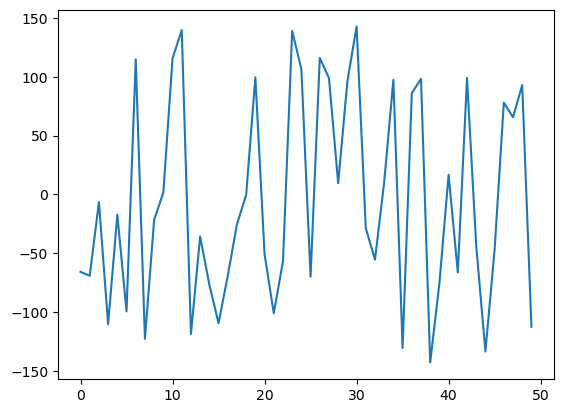


Recompensa de Media: -4.772079192669785 



In [28]:
# Evaluamos al Generador 
rewardMean=gan1.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 2

### Construcción de base de datos experta con 2 trayectoria 

In [29]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_LunarLander.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]

	 Estados siguientes: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]

	 Recompensas: [   0    0   

In [30]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 1)
print(longitud_trayectoria)

1127


In [31]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [32]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [33]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 901
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 226


In [34]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [35]:
gan2=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [36]:
tf.config.run_functions_eagerly(True)
gan2.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [37]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE=140

history=gan2.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.6126106

g_loss= 0.28688005
1/7 [===>..........................] - ETA: 1:02:40 - d_loss: 2.6126 - g_loss: 0.2869


d_loss= 2.5637934

g_loss= 0.2744208
2/7 [=======>......................] - ETA: 52:17 - d_loss: 2.5882 - g_loss: 0.2807  


d_loss= 2.6233482

g_loss= 0.65300083
3/7 [===========>..................] - ETA: 41:51 - d_loss: 2.5999 - g_loss: 0.4048


d_loss= 2.5651226

g_loss= -1.5215373
4/7 [================>.............] - ETA: 31:24 - d_loss: 2.5912 - g_loss: -0.0768


d_loss= 2.600709

g_loss= 1.4750057
5/7 [====================>.........] - ETA: 20:56 - d_loss: 2.5931 - g_loss: 0.2336 


d_loss= 2.6092846

g_loss= 0.5497137
6/7 [========================>.....] - ETA: 10:31 - d_loss: 2.5958 - g_loss: 0.2862


d_loss= 2.591103

g_loss= 1.1361111
7/7 [==============================] - 4414s 631s/step - d_loss: 2.5951 - g_loss: 0.4077


### Evaluación de GAIL

In [38]:
# Evaluamos el Discriminador de GAIL en el TEST
gan2.evaluate_D(X_test)


1/1 [==============================] - 0s 18ms/step - loss: 0.6447 - accuracy: 0.1667
>Loss real: 
0.706373393535614
>Loss fake: 
0.6446850299835205


Episode  0 Total reward: 71.85572613323642
Episode  1 Total reward: 15.837036654502285
Episode  2 Total reward: -136.2993725393409
Episode  3 Total reward: -60.682250799936405
Episode  4 Total reward: 56.34106943939117
Episode  5 Total reward: -88.13253155931835
Episode  6 Total reward: 6.345599641538826
Episode  7 Total reward: -1.041510638060501
Episode  8 Total reward: 113.15960910654351
Episode  9 Total reward: -58.46466281997603
Episode  10 Total reward: -64.10196624195075
Episode  11 Total reward: -217.22695854402994
Episode  12 Total reward: -234.92092755684277
Episode  13 Total reward: -11.611082862340524
Episode  14 Total reward: 17.90190638358571
Episode  15 Total reward: 27.948966187535667
Episode  16 Total reward: 2.9793351873499887
Episode  17 Total reward: -21.32607850053516
Episode  18 Total reward: 14.141006896301938
Episode  19 Total reward: 48.892853516847865
Episode  20 Total reward: 129.58451146764915
Episode  21 Total reward: -38.75449071239643
Episode  22 Total re

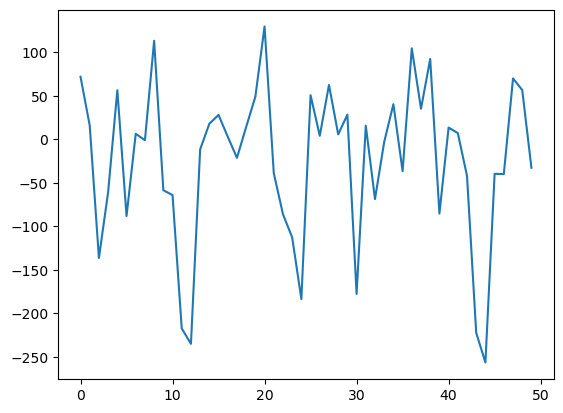


Recompensa de Media: -24.565050772648057 



In [39]:
# Evaluamos al Generador 
rewardMean=gan2.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 3

### Construcción de base de datos experta con 3 trayectoria 

In [40]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_LunarLander.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]

	 Estados siguientes: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]

	 Recompensas: [   0    0   

In [41]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 2)
print(longitud_trayectoria)

1572


In [42]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [43]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [44]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 1257
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 315


In [45]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [46]:
gan3=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [47]:
tf.config.run_functions_eagerly(True)
gan3.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [48]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)


BATCH_SIZE=140

history=gan3.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.5642962

g_loss= 3.6984348
1/9 [==>...........................] - ETA: 1:23:00 - d_loss: 2.5643 - g_loss: 3.6984


d_loss= 2.5794773

g_loss= -2.0148838
2/9 [=====>........................] - ETA: 1:13:13 - d_loss: 2.5719 - g_loss: 0.8418


d_loss= 2.5617425

g_loss= 0.4959279
3/9 [=========>....................] - ETA: 1:02:43 - d_loss: 2.5685 - g_loss: 0.7265


d_loss= 2.5827143

g_loss= -1.7060982
4/9 [============>.................] - ETA: 52:15 - d_loss: 2.5721 - g_loss: 0.1183  


d_loss= 2.5795329

g_loss= 2.1425328
5/9 [===============>..............] - ETA: 41:52 - d_loss: 2.5736 - g_loss: 0.5232


d_loss= 2.5457685

g_loss= 1.5198834
6/9 [===================>..........] - ETA: 31:25 - d_loss: 2.5689 - g_loss: 0.6893


d_loss= 2.566185

g_loss= 0.36242062
7/9 [======================>.......] - ETA: 20:57 - d_loss: 2.5685 - g_loss: 0.6426


d_loss= 2.5601072

g_loss= 1.7800821
8/9 [=========================>....] - ETA: 10:29 - d_loss: 2.5675 - g_loss: 0.7848


d_l

### Evaluación de GAIL

In [49]:
# Evaluamos el Discriminador de GAIL en el TEST
gan3.evaluate_D(X_test)


1/1 [==============================] - 0s 18ms/step - loss: 0.6508 - accuracy: 0.0699
>Loss real: 
0.6565201282501221
>Loss fake: 
0.650819718837738


Episode  0 Total reward: -72.31402062749942
Episode  1 Total reward: -72.82635372634434
Episode  2 Total reward: -236.43177683947314
Episode  3 Total reward: -46.96037022409062
Episode  4 Total reward: -200.28283863625387
Episode  5 Total reward: -106.77415451676441
Episode  6 Total reward: 39.72989431036487
Episode  7 Total reward: 17.6938150233697
Episode  8 Total reward: -142.23441596348565
Episode  9 Total reward: -28.167648988671132
Episode  10 Total reward: -49.51776226407644
Episode  11 Total reward: -63.11072387901616
Episode  12 Total reward: 6.061000612241415
Episode  13 Total reward: -258.91956189520795
Episode  14 Total reward: 47.30874252226526
Episode  15 Total reward: -156.00352161997262
Episode  16 Total reward: 23.256810344482602
Episode  17 Total reward: -36.346343071287606
Episode  18 Total reward: -54.00286859789475
Episode  19 Total reward: -18.906079928189826
Episode  20 Total reward: -39.38868636603286
Episode  21 Total reward: -25.6849429397039
Episode  22 Total

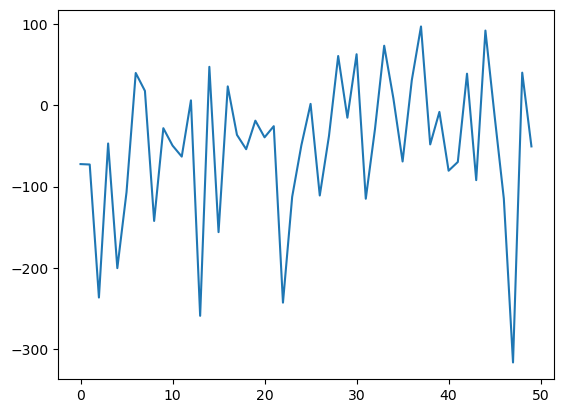


Recompensa de Media: -50.861321935359996 



In [50]:
# Evaluamos al Generador 
rewardMean=gan3.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 4

### Construcción de base de datos experta con 4 trayectoria 

In [51]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_LunarLander.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]

	 Estados siguientes: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]

	 Recompensas: [   0    0   

In [52]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 3)
print(longitud_trayectoria)

2168


In [53]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [54]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [55]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 1734
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 434


In [56]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [57]:
gan4=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [58]:
tf.config.run_functions_eagerly(True)
gan4.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [59]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE=140

history=gan4.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.5474615

g_loss= -1.3547312
 1/13 [=>............................] - ETA: 2:04:47 - d_loss: 2.5475 - g_loss: -1.3547


d_loss= 2.5195522

g_loss= 1.358638
 2/13 [===>..........................] - ETA: 1:55:17 - d_loss: 2.5335 - g_loss: 0.0020 


d_loss= 2.5349505

g_loss= 3.3267617
 3/13 [=====>........................] - ETA: 1:44:50 - d_loss: 2.5340 - g_loss: 1.1102


d_loss= 2.5660439

g_loss= 2.1828837
 4/13 [========>.....................] - ETA: 1:34:28 - d_loss: 2.5420 - g_loss: 1.3784


d_loss= 2.6124744

g_loss= -0.51852167
 5/13 [==========>...................] - ETA: 1:24:07 - d_loss: 2.5561 - g_loss: 0.9990


d_loss= 2.532445

g_loss= 1.0698951
 6/13 [============>.................] - ETA: 1:13:36 - d_loss: 2.5522 - g_loss: 1.0108


d_loss= 2.5527377

g_loss= 3.062141
 7/13 [===============>..............] - ETA: 1:03:07 - d_loss: 2.5522 - g_loss: 1.3039


d_loss= 2.554758

g_loss= 0.7253308
 8/13 [=================>............] - ETA: 52:38 - d_loss: 2.5526 -

### Evaluación de GAIL

In [60]:
# Evaluamos el Discriminador de GAIL en el TEST
gan4.evaluate_D(X_test)


1/1 [==============================] - 0s 18ms/step - loss: 0.6076 - accuracy: 0.0000e+00
>Loss real: 
0.6223491430282593
>Loss fake: 
0.607596218585968


Episode  0 Total reward: -20.55237690713666
Episode  1 Total reward: 47.9567391225452
Episode  2 Total reward: 58.5064429096731
Episode  3 Total reward: -15.628172840705531
Episode  4 Total reward: -99.7808453416373
Episode  5 Total reward: -89.48992180962732
Episode  6 Total reward: 37.740649038773455
Episode  7 Total reward: 12.041819503110375
Episode  8 Total reward: -98.33723785052321
Episode  9 Total reward: -131.2450373513612
Episode  10 Total reward: -83.98167122828004
Episode  11 Total reward: -122.60738207164309
Episode  12 Total reward: -47.17594622994296
Episode  13 Total reward: -106.67931472938511
Episode  14 Total reward: -61.652991766106226
Episode  15 Total reward: 12.177032890975124
Episode  16 Total reward: -20.404166144709322
Episode  17 Total reward: 21.520434150083247
Episode  18 Total reward: -84.78149726922621
Episode  19 Total reward: -144.33790224129802
Episode  20 Total reward: 51.15857670300004
Episode  21 Total reward: -251.85607848924718
Episode  22 Total r

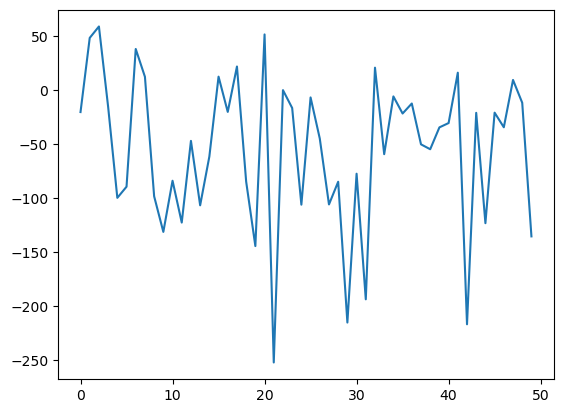


Recompensa de Media: -55.575640795824754 



In [61]:
# Evaluamos al Generador 
rewardMean=gan4.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 5

### Construcción de base de datos experta con 2 trayectoria 

In [62]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_LunarLander.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]

	 Estados siguientes: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]

	 Recompensas: [   0    0   

In [63]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 4)
print(longitud_trayectoria)

3158


In [64]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [65]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [66]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 2526
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 632


In [67]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [68]:
gan5=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [69]:
tf.config.run_functions_eagerly(True)
gan5.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [70]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)


BATCH_SIZE=140

history=gan5.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.543023

g_loss= 9.461582
 1/19 [>.............................] - ETA: 3:11:42 - d_loss: 2.5430 - g_loss: 9.4616


d_loss= 2.5063343

g_loss= -0.32061815
 2/19 [==>...........................] - ETA: 3:02:12 - d_loss: 2.5247 - g_loss: 4.5705


d_loss= 2.5188394

g_loss= -0.26085111
 3/19 [===>..........................] - ETA: 2:53:09 - d_loss: 2.5227 - g_loss: 2.9600


d_loss= 2.4777339

g_loss= 1.2249987
 4/19 [=====>........................] - ETA: 2:40:55 - d_loss: 2.5115 - g_loss: 2.5263


d_loss= 2.490281

g_loss= 1.1914097
 5/19 [======>.......................] - ETA: 2:29:33 - d_loss: 2.5072 - g_loss: 2.2593


d_loss= 2.5513465

g_loss= 0.35121116
 6/19 [========>.....................] - ETA: 2:18:38 - d_loss: 2.5146 - g_loss: 1.9413


d_loss= 2.4919071

g_loss= 0.3636564
 7/19 [==========>...................] - ETA: 2:08:09 - d_loss: 2.5114 - g_loss: 1.7159


d_loss= 2.461596

g_loss= -2.8018882
 8/19 [===========>..................] - ETA: 1:57:17 - d_loss: 2.505

### Evaluación de GAIL

In [71]:
# Evaluamos el Discriminador de GAIL en el TEST
gan5.evaluate_D(X_test)


1/1 [==============================] - 0s 17ms/step - loss: 0.5134 - accuracy: 0.0108
>Loss real: 
0.5465038418769836
>Loss fake: 
0.5134280323982239


Episode  0 Total reward: -16.13181339793954
Episode  1 Total reward: -93.80931841089297
Episode  2 Total reward: 53.37433571564671
Episode  3 Total reward: 37.582747422396025
Episode  4 Total reward: -129.81237240774828
Episode  5 Total reward: 18.256581101320748
Episode  6 Total reward: -256.09825130575086
Episode  7 Total reward: -48.44766617676753
Episode  8 Total reward: -133.35684643159053
Episode  9 Total reward: -105.05256590022681
Episode  10 Total reward: -216.82672840393508
Episode  11 Total reward: -76.57865906882549
Episode  12 Total reward: -45.584877979371626
Episode  13 Total reward: -160.0981900307321
Episode  14 Total reward: -48.83170261540934
Episode  15 Total reward: -260.20531335818055
Episode  16 Total reward: 14.681675062523283
Episode  17 Total reward: -77.12215418796131
Episode  18 Total reward: 38.86937880121204
Episode  19 Total reward: -226.1263339270816
Episode  20 Total reward: -56.29886584342557
Episode  21 Total reward: -187.15609409034857
Episode  22 To

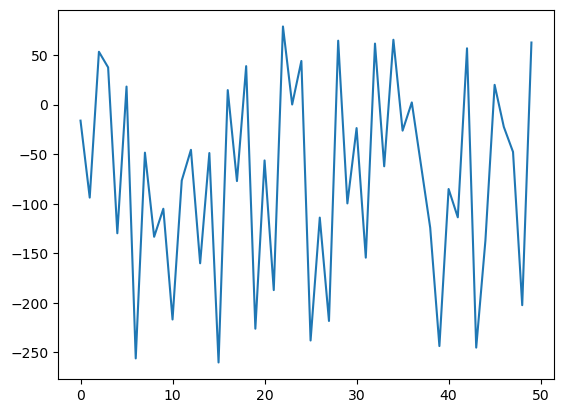


Recompensa de Media: -74.74532703096477 



In [72]:
# Evaluamos al Generador 
rewardMean=gan5.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 6

### Construcción de base de datos experta con 6 trayectoria 

In [73]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_LunarLander.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]

	 Estados siguientes: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]

	 Recompensas: [   0    0   

In [74]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 5)
print(longitud_trayectoria)

4158


In [75]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [76]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [77]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 3326
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 832


In [78]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [79]:
gan6=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [80]:
tf.config.run_functions_eagerly(True)
gan6.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [81]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)


BATCH_SIZE=140

history=gan6.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.465796

g_loss= 3.412959
 1/24 [>.............................] - ETA: 4:02:13 - d_loss: 2.4658 - g_loss: 3.4130


d_loss= 2.4340496

g_loss= 1.7210047
 2/24 [=>............................] - ETA: 3:50:36 - d_loss: 2.4499 - g_loss: 2.5670


d_loss= 2.463148

g_loss= -8.109693
 3/24 [==>...........................] - ETA: 3:40:18 - d_loss: 2.4543 - g_loss: -0.9919


d_loss= 2.4646087

g_loss= 3.50794
 4/24 [====>.........................] - ETA: 3:29:59 - d_loss: 2.4569 - g_loss: 0.1331 


d_loss= 2.4482203

g_loss= 1.6177206
 5/24 [=====>........................] - ETA: 3:19:43 - d_loss: 2.4552 - g_loss: 0.4300


d_loss= 2.3968487

g_loss= -2.7182665
 6/24 [======>.......................] - ETA: 3:09:23 - d_loss: 2.4454 - g_loss: -0.0947


d_loss= 2.4437656

g_loss= -0.18237545
 7/24 [=======>......................] - ETA: 2:58:54 - d_loss: 2.4452 - g_loss: -0.1072


d_loss= 2.4387355

g_loss= 1.130614
 8/24 [=========>....................] - ETA: 2:48:22 - d_loss: 2.4444

### Evaluación de GAIL

In [82]:
# Evaluamos el Discriminador de GAIL en el TEST
gan6.evaluate_D(X_test)


1/1 [==============================] - 0s 18ms/step - loss: 0.4649 - accuracy: 0.0000e+00
>Loss real: 
0.45526251196861267
>Loss fake: 
0.46493685245513916


Episode  0 Total reward: 49.614992887832585
Episode  1 Total reward: -72.26972885802738
Episode  2 Total reward: -1.1400129929320286
Episode  3 Total reward: -18.385077194727202
Episode  4 Total reward: -6.995822928518521
Episode  5 Total reward: 110.92016951295429
Episode  6 Total reward: -130.3635086843739
Episode  7 Total reward: -0.7858132460605276
Episode  8 Total reward: -40.41473685176731
Episode  9 Total reward: -31.581267810599783
Episode  10 Total reward: 15.34487932624259
Episode  11 Total reward: 3.698089874608799
Episode  12 Total reward: -79.15635246836943
Episode  13 Total reward: -39.23973735684007
Episode  14 Total reward: -58.13214965139417
Episode  15 Total reward: -49.57215285686158
Episode  16 Total reward: -20.478109492987286
Episode  17 Total reward: 27.165625215278084
Episode  18 Total reward: -36.00916876077777
Episode  19 Total reward: 13.0681604512951
Episode  20 Total reward: -133.57523008968556
Episode  21 Total reward: -1.746934585387628
Episode  22 Total 

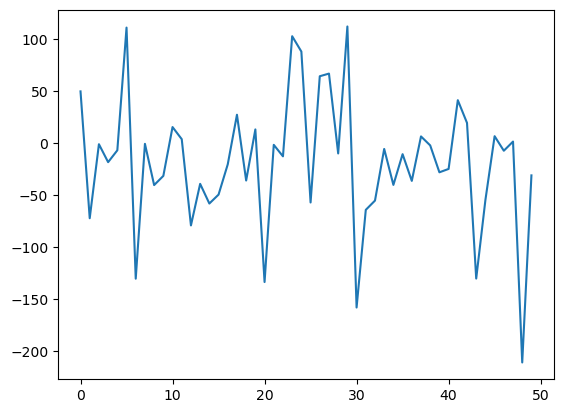


Recompensa de Media: -18.64159356294645 



In [83]:
# Evaluamos al Generador 
rewardMean=gan6.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 7

### Construcción de base de datos experta con 7 trayectoria 

In [84]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_LunarLander.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]

	 Estados siguientes: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]

	 Recompensas: [   0    0   

In [85]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 6)
print(longitud_trayectoria)

4680


In [86]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [87]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [88]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 3744
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 936


In [89]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [90]:
gan7=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [91]:
tf.config.run_functions_eagerly(True)
gan7.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [92]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)


BATCH_SIZE=140

history=gan7.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.3759208

g_loss= 0.41692293
 1/27 [>.............................] - ETA: 4:35:48 - d_loss: 2.3759 - g_loss: 0.4169


d_loss= 2.3713899

g_loss= 0.061330676
 2/27 [=>............................] - ETA: 4:26:13 - d_loss: 2.3737 - g_loss: 0.2391


d_loss= 2.3411994

g_loss= -4.24168
 3/27 [==>...........................] - ETA: 4:16:53 - d_loss: 2.3628 - g_loss: -1.2545


d_loss= 2.3650389

g_loss= -4.116773
 4/27 [===>..........................] - ETA: 4:05:00 - d_loss: 2.3634 - g_loss: -1.9700


d_loss= 2.344535

g_loss= 2.0137851
 5/27 [====>.........................] - ETA: 3:53:31 - d_loss: 2.3596 - g_loss: -1.1733


d_loss= 2.3445194

g_loss= 0.23508817
 6/27 [=====>........................] - ETA: 3:42:39 - d_loss: 2.3571 - g_loss: -0.9386


d_loss= 2.3336897

g_loss= -0.7506277
 7/27 [======>.......................] - ETA: 3:31:55 - d_loss: 2.3538 - g_loss: -0.9117


d_loss= 2.2907

g_loss= 3.512479
 8/27 [=======>......................] - ETA: 3:21:12 - d_loss: 2.3

### Evaluación de GAIL

In [93]:
# Evaluamos el Discriminador de GAIL en el TEST
gan7.evaluate_D(X_test)


1/1 [==============================] - 0s 18ms/step - loss: 0.2852 - accuracy: 0.0000e+00
>Loss real: 
0.3338671028614044
>Loss fake: 
0.2852312922477722


Episode  0 Total reward: -88.370858572964
Episode  1 Total reward: -117.04034467417604
Episode  2 Total reward: -206.98803273041028
Episode  3 Total reward: 45.75899463859486
Episode  4 Total reward: -195.70597891581247
Episode  5 Total reward: -128.09387532557156
Episode  6 Total reward: -42.054682631027006
Episode  7 Total reward: 9.743566555436402
Episode  8 Total reward: -81.16957064721942
Episode  9 Total reward: 20.720311756427513
Episode  10 Total reward: 2.940022449135057
Episode  11 Total reward: -198.82565477660802
Episode  12 Total reward: -172.11147739860922
Episode  13 Total reward: 65.68098756501541
Episode  14 Total reward: -13.355258798637493
Episode  15 Total reward: -216.89313806267484
Episode  16 Total reward: 36.04001013991979
Episode  17 Total reward: -227.5957654647936
Episode  18 Total reward: -48.29967415450177
Episode  19 Total reward: -58.25638654399516
Episode  20 Total reward: -101.16685405719623
Episode  21 Total reward: 31.453382569805864
Episode  22 Total

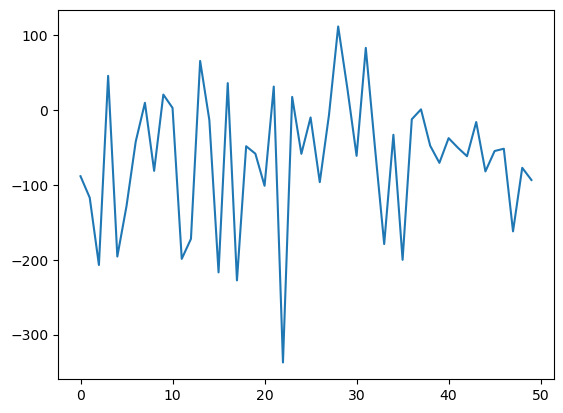


Recompensa de Media: -65.79890709771627 



In [94]:
# Evaluamos al Generador 
rewardMean=gan7.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 8

### Construcción de base de datos experta con 8 trayectoria 

In [95]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_LunarLander.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]

	 Estados siguientes: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]

	 Recompensas: [   0    0   

In [96]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 7)
print(longitud_trayectoria)

5314


In [97]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [98]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [99]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 4251
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 1063


In [100]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [101]:
gan8=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [102]:
tf.config.run_functions_eagerly(True)
gan8.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [103]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)


BATCH_SIZE=140

history=gan8.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.248061

g_loss= 4.7266197
 1/31 [..............................] - ETA: 5:27:47 - d_loss: 2.2481 - g_loss: 4.7266


d_loss= 2.2078488

g_loss= -3.3087802
 2/31 [>.............................] - ETA: 5:14:08 - d_loss: 2.2280 - g_loss: 0.7089


d_loss= 2.2051404

g_loss= 1.3656416
 3/31 [=>............................] - ETA: 5:03:58 - d_loss: 2.2204 - g_loss: 0.9278


d_loss= 2.223616

g_loss= -1.7462369
 4/31 [==>...........................] - ETA: 4:50:31 - d_loss: 2.2212 - g_loss: 0.2593


d_loss= 2.1938946

g_loss= 0.17841457
 5/31 [===>..........................] - ETA: 4:38:08 - d_loss: 2.2157 - g_loss: 0.2431


d_loss= 2.2232392

g_loss= 0.4615737
 6/31 [====>.........................] - ETA: 4:26:26 - d_loss: 2.2170 - g_loss: 0.2795


d_loss= 2.241694

g_loss= 1.7781186
 7/31 [=====>........................] - ETA: 4:15:10 - d_loss: 2.2205 - g_loss: 0.4936


d_loss= 2.1758153

g_loss= 2.5593588
 8/31 [======>.......................] - ETA: 4:04:04 - d_loss: 2.2149 

### Evaluación de GAIL

In [104]:
# Evaluamos el Discriminador de GAIL en el TEST
gan8.evaluate_D(X_test)


1/1 [==============================] - 0s 18ms/step - loss: 0.1579 - accuracy: 0.0000e+00
>Loss real: 
0.19892017543315887
>Loss fake: 
0.15790076553821564


Episode  0 Total reward: -13.761561552140403
Episode  1 Total reward: -47.53269582455425
Episode  2 Total reward: -215.98041765896144
Episode  3 Total reward: 91.40428488750565
Episode  4 Total reward: -46.32231014442836
Episode  5 Total reward: -297.0352495265773
Episode  6 Total reward: -80.03753948613965
Episode  7 Total reward: -41.38495225931935
Episode  8 Total reward: 99.16289276110065
Episode  9 Total reward: -246.6269219552378
Episode  10 Total reward: 21.445958273059517
Episode  11 Total reward: 22.531202594726054
Episode  12 Total reward: -128.62085156646475
Episode  13 Total reward: 62.80160345707594
Episode  14 Total reward: 71.5012775994457
Episode  15 Total reward: -254.52996840826512
Episode  16 Total reward: -60.46902874391471
Episode  17 Total reward: -157.01955040684038
Episode  18 Total reward: -185.85116851035508
Episode  19 Total reward: -10.308644012413154
Episode  20 Total reward: 75.7092171616949
Episode  21 Total reward: 2.42017257503592
Episode  22 Total rewa

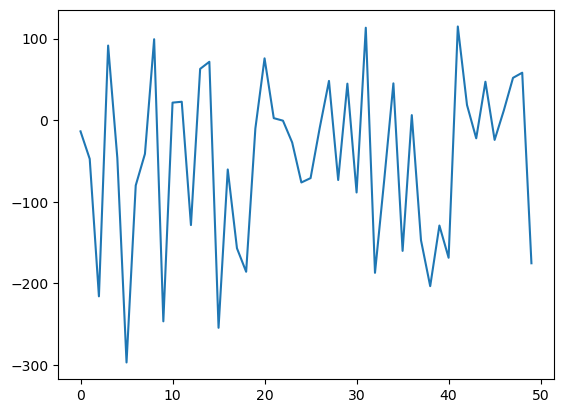


Recompensa de Media: -48.350116562256225 



In [105]:
# Evaluamos al Generador 
rewardMean=gan8.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 9

### Construcción de base de datos experta con 9 trayectoria 

In [106]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_LunarLander.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]

	 Estados siguientes: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]

	 Recompensas: [   0    0   

In [107]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 8)
print(longitud_trayectoria)

5799


In [108]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [109]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [110]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 4639
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 1160


In [111]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [112]:
gan9=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [113]:
tf.config.run_functions_eagerly(True)
gan9.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [114]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)


BATCH_SIZE=140

history=gan9.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.124025

g_loss= 0.28816265
 1/34 [..............................] - ETA: 5:55:17 - d_loss: 2.1240 - g_loss: 0.2882


d_loss= 2.1034985

g_loss= 2.4307163
 2/34 [>.............................] - ETA: 5:44:01 - d_loss: 2.1138 - g_loss: 1.3594


d_loss= 2.0511787

g_loss= 1.5543396
 3/34 [=>............................] - ETA: 5:32:00 - d_loss: 2.0929 - g_loss: 1.4244


d_loss= 2.1163745

g_loss= 0.64371765
 4/34 [==>...........................] - ETA: 5:20:46 - d_loss: 2.0988 - g_loss: 1.2292


d_loss= 2.102485

g_loss= -0.043194193
 5/34 [===>..........................] - ETA: 5:11:36 - d_loss: 2.0995 - g_loss: 0.9747


d_loss= 2.065818

g_loss= 2.3824124
 6/34 [====>.........................] - ETA: 5:01:53 - d_loss: 2.0939 - g_loss: 1.2094


d_loss= 2.0884707

g_loss= 2.5593297
 7/34 [=====>........................] - ETA: 4:51:21 - d_loss: 2.0931 - g_loss: 1.4022


d_loss= 2.0788853

g_loss= -0.9396035
 8/34 [======>.......................] - ETA: 4:40:37 - d_loss: 2.09

### Evaluación de GAIL

In [115]:
# Evaluamos el Discriminador de GAIL en el TEST
gan9.evaluate_D(X_test)


1/1 [==============================] - 0s 18ms/step - loss: 0.0627 - accuracy: 0.0000e+00
>Loss real: 
0.08535801619291306
>Loss fake: 
0.06273077428340912


Episode  0 Total reward: -176.32281844857607
Episode  1 Total reward: -46.57658499256178
Episode  2 Total reward: -98.41151142594204
Episode  3 Total reward: -24.270210490864404
Episode  4 Total reward: -37.611496613321044
Episode  5 Total reward: -82.18980509758322
Episode  6 Total reward: -37.35703946691674
Episode  7 Total reward: -55.44536238726768
Episode  8 Total reward: -69.79560368106424
Episode  9 Total reward: 48.98902068517353
Episode  10 Total reward: -42.99314865525378
Episode  11 Total reward: -43.13733042719538
Episode  12 Total reward: -206.49067595611754
Episode  13 Total reward: -117.2679796747916
Episode  14 Total reward: 21.093277601675084
Episode  15 Total reward: -125.75721519447487
Episode  16 Total reward: -58.52604795079196
Episode  17 Total reward: 48.58778289449566
Episode  18 Total reward: -62.798097491528324
Episode  19 Total reward: 30.18009317957936
Episode  20 Total reward: -33.170172103976
Episode  21 Total reward: -32.2768002288673
Episode  22 Total re

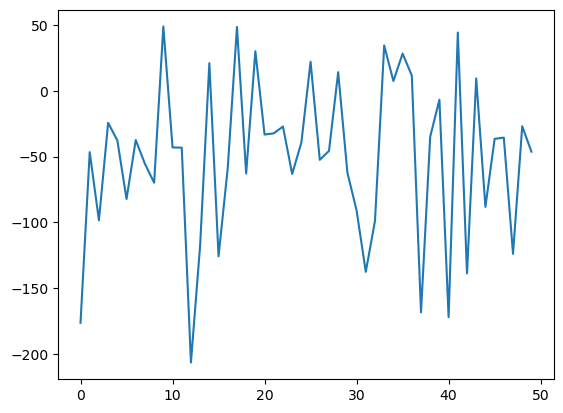


Recompensa de Media: -50.4782902835412 



In [116]:
# Evaluamos al Generador 
rewardMean=gan9.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 10

### Construcción de base de datos experta con 10 trayectoria 

In [117]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_LunarLander.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]

	 Estados siguientes: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]

	 Recompensas: [   0    0   

In [118]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 9)
print(longitud_trayectoria)

6310


In [119]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [120]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [121]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 5048
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 1262


In [122]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [123]:
gan10=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [124]:
tf.config.run_functions_eagerly(True)
gan10.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [125]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)


BATCH_SIZE=140

history=gan10.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 1.9984837

g_loss= 1.7866338
 1/37 [..............................] - ETA: 6:17:08 - d_loss: 1.9985 - g_loss: 1.7866


d_loss= 1.9873598

g_loss= 0.6421348
 2/37 [>.............................] - ETA: 6:10:20 - d_loss: 1.9929 - g_loss: 1.2144


d_loss= 2.0418377

g_loss= -4.203281
 3/37 [=>............................] - ETA: 5:59:05 - d_loss: 2.0092 - g_loss: -0.5915


d_loss= 1.9265338

g_loss= 1.676593
 4/37 [==>...........................] - ETA: 5:48:45 - d_loss: 1.9886 - g_loss: -0.0245


d_loss= 1.9729661

g_loss= 5.337543
 5/37 [===>..........................] - ETA: 5:37:52 - d_loss: 1.9854 - g_loss: 1.0479 


d_loss= 1.9692521

g_loss= 0.66150916
 6/37 [===>..........................] - ETA: 5:27:40 - d_loss: 1.9827 - g_loss: 0.9835


d_loss= 1.9301258

g_loss= 1.0141371
 7/37 [====>.........................] - ETA: 5:16:59 - d_loss: 1.9752 - g_loss: 0.9879


d_loss= 1.9888688

g_loss= -2.9833286
 8/37 [=====>........................] - ETA: 5:06:35 - d_loss: 1.97

### Evaluación de GAIL

In [126]:
# Evaluamos el Discriminador de GAIL en el TEST
gan10.evaluate_D(X_test)


1/1 [==============================] - 0s 18ms/step - loss: 0.0100 - accuracy: 0.0000e+00
>Loss real: 
0.02682928554713726
>Loss fake: 
0.009971534833312035


Episode  0 Total reward: -145.12779922441956
Episode  1 Total reward: 34.77909469453763
Episode  2 Total reward: -156.9365348623307
Episode  3 Total reward: -3.0430803208422503
Episode  4 Total reward: -18.135955495962293
Episode  5 Total reward: -93.54984317078959
Episode  6 Total reward: -234.0998325792682
Episode  7 Total reward: -184.14762538580572
Episode  8 Total reward: 23.150688651745767
Episode  9 Total reward: -116.40344880770112
Episode  10 Total reward: 30.12397156497222
Episode  11 Total reward: -213.90904863522059
Episode  12 Total reward: -135.2581736234472
Episode  13 Total reward: -107.53317413119368
Episode  14 Total reward: -113.89783943565827
Episode  15 Total reward: 12.803259220179086
Episode  16 Total reward: 4.539011333393631
Episode  17 Total reward: -57.79714178689339
Episode  18 Total reward: -166.36978977417488
Episode  19 Total reward: -29.269432443139195
Episode  20 Total reward: -64.03738236142522
Episode  21 Total reward: -163.153096351689
Episode  22 To

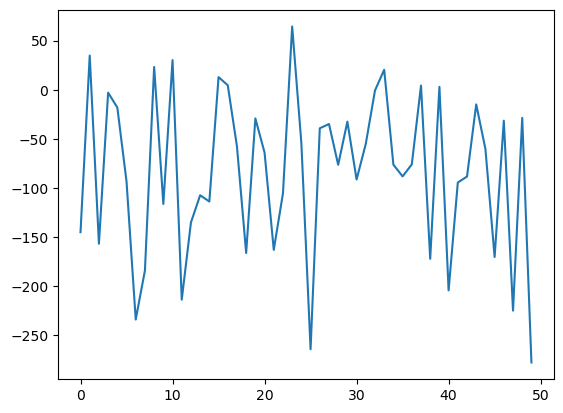


Recompensa de Media: -83.39953273390678 



In [127]:
# Evaluamos al Generador 
rewardMean=gan10.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')